# Project Overview

In this project, we compare eight machine-learning algorithms for time-series forecasting of synthetic equity returns, derived from lagged stock characteristics and macroeconomic factors. To ensure clean, modular, and reusable code, we adopt an object-oriented design:

All regressors inherit from a single BaseRegressor class, which centralizes

- data preprocessing (scaling),

- training and hyperparameter tuning,

- prediction and evaluation metrics (out-of-sample R², zero-return R², cross-sectional R², MSE),

- diagnostic plotting, and

- feature‐importance extraction.

Each specific model (OLS, Elastic Net, PCR, PLS, spline-based GLM, Random Forest, Gradient Boosting, Neural Network) only needs to implement its own pipeline and—where needed—custom training logic. This inheritance structure drastically reduces boilerplate, makes it straightforward to add or extend models, and keeps our analysis code concise.

Beyond raw predictive performance, we also:

- Benchmark forecasts via the Diebold–Mariano test for statistically comparing model errors,

- Visualize feature importances across models with a unified heatmap, and

- Assess economic value through a decile portfolio analysis, ranking stocks by predicted return and comparing realized Sharpe ratios.

This end-to-end, OOP-driven framework delivers both rigorous model evaluation and actionable financial insights.

Import all needed libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from data_processing import split_data

from models.linear_models.ordinary_least_squares_regression import OLSModel
from models.linear_models.elastic_net_regression import ElasticNetModel
from models.linear_models.principal_component_regression import PCRModel
from models.linear_models.partial_least_squares_regression import PLSModel
from models.linear_models.generalized_linear_model import GLMModel
from models.non_linear_models.neural_network import NeuralNetworkModel
from models.non_linear_models.gradient_boosting import GradientBoostingModel
from models.non_linear_models.random_forest import RandomForestModel

from utility.variable_importance import drop_feature_importance
from utility.prediction_wrapper import PredictionWrapper
from utility.diebold_mariano_test import diebold_mariano
from utility.decile_portfolio import DecilePortfolioAnalysis



Part 1 & 2: Data Generation and Preprocessing

In [2]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data()

Part 3: Model Training Section

In [3]:
# --- OLS Model Training and Evaluation ---
ols_model = OLSModel(n_stocks=10)
ols_model.train(X_train, y_train)

# --- ElasticNet Model Tuning ---
elastic_net_model = ElasticNetModel(n_stocks=10)
elastic_net_model.train(X_train, y_train, X_val, y_val)

# --- Principal Component Regression (PCR) ---
pcr_model = PCRModel(n_stocks=10)
pcr_model.train(X_train, y_train, X_val, y_val)

# --- Partial Least Squares Regression (PLS) ---
pls_model = PLSModel(n_stocks=10)
pls_model.train(X_train, y_train, X_val, y_val)

# --- Generalized Linear Model (Spline Transformation + ElasticNet) ---
glm = GLMModel(n_stocks=10)
glm.train(X_train, y_train, X_val, y_val)

# --- non-linear models ---

# --- Neural Network Model ---
nn_model = NeuralNetworkModel(n_stocks=10)
nn_model.train(X_train, y_train, X_val, y_val)

# --- Gradient Boosting Regressor ---
gradient_boosting_model = GradientBoostingModel(n_stocks=10)
gradient_boosting_model.train(X_train, y_train, X_val, y_val)

# --- Random Forest Regressor ---
random_forest_model = RandomForestModel(n_stocks=10)
random_forest_model.train(X_train, y_train, X_val, y_val)

Part 4: Prediction Wrappers

In [4]:
# alle Modelle im Dictionary sammeln
models = {
    'OLS':                ols_model,
    'ElasticNet':         elastic_net_model,
    'PCR':                pcr_model,
    'PLS':                pls_model,
    'GLM':                glm,
    'NeuralNetwork':      nn_model,
    'GradientBoosting':   gradient_boosting_model,
    'RandomForest':       random_forest_model
}

# Wrapper instanziieren (alle Modelle müssen bereits trainiert sein)
wrapper = PredictionWrapper(models)

# Auf dem Test-Set alle Vorhersagen sammeln
df_preds = wrapper.predict(X_test)
print(df_preds.head())   # zeigt die ersten Zeilen mit 8 Spalten

# Bei Bedarf direkt z.B. in Part 6:
# Out-of-Sample R² für alle Modelle in einer Schleife
for name in df_preds.columns:
    y_pred = df_preds[name].values
    metrics = models[name].evaluate(X_test, y_test)
    models[name].print_summary(f"{name} Test", metrics)

        OLS  ElasticNet       PCR       PLS       GLM  NeuralNetwork  \
0  0.521236    0.512437  0.521236  0.521236  0.489261       0.364968   
1  0.544760    0.537141  0.544760  0.544760  0.512238       0.364529   
2  0.340867    0.341851  0.340867  0.340867  0.343708       0.364404   
3  0.411993    0.409824  0.411993  0.411993  0.417225       0.365138   
4  0.534802    0.525441  0.534802  0.534802  0.503052       0.365011   

   GradientBoosting  RandomForest  
0          0.347248      0.274552  
1          0.422926      0.377828  
2          0.287822      0.177643  
3          0.292437      0.253911  
4          0.380795      0.269738  
=== OLS Test ===
mse       : 0.0000
r2        : 1.0000
r2_zero   : 1.0000
r2_cs     : 1.0000

=== ElasticNet Test ===
mse       : 0.0000
r2        : 0.9983
r2_zero   : 0.9998
r2_cs     : 0.9983

=== PCR Test ===
mse       : 0.0000
r2        : 1.0000
r2_zero   : 1.0000
r2_cs     : 1.0000

=== PLS Test ===
mse       : 0.0000
r2        : 1.0000
r2_zero

Part 5: Full-Sample Time Series Plots - to see the predictions vs. actuals

OLS Model Diagnostics:


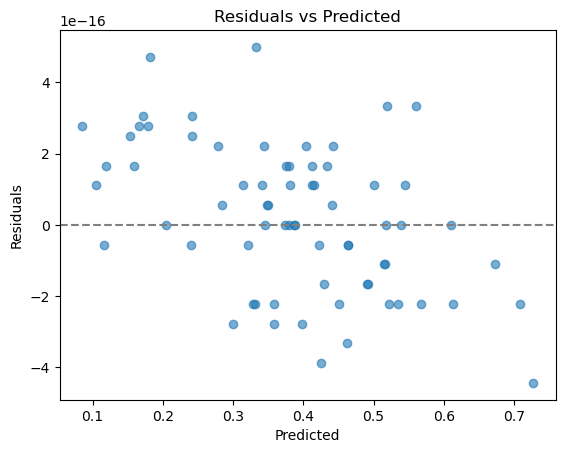

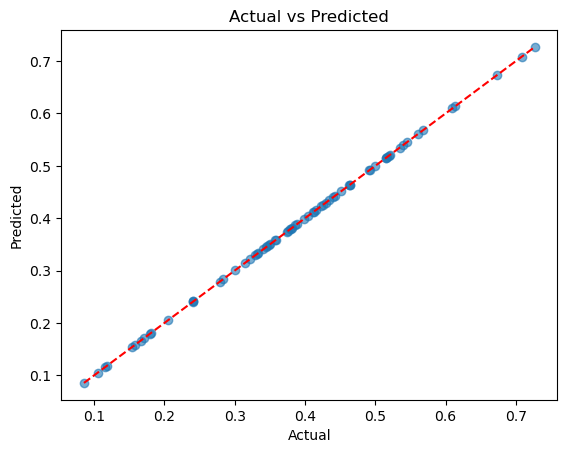

ElasticNet Model Diagnostics:


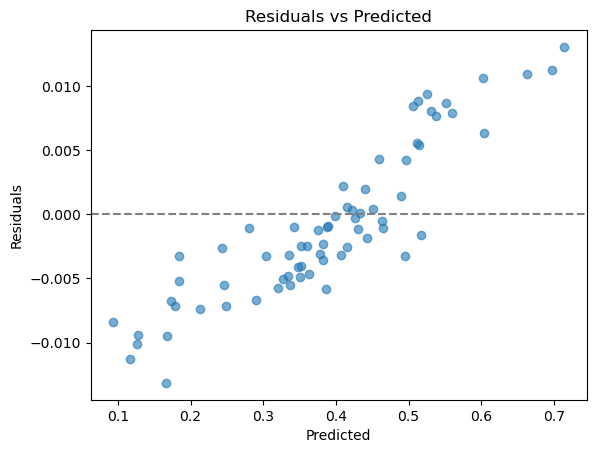

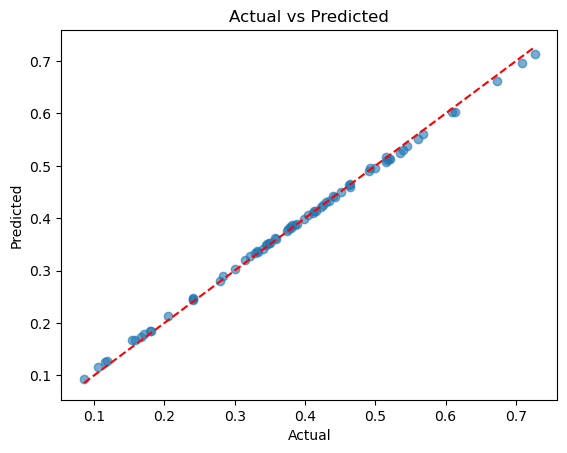

PCR Model Diagnostics:


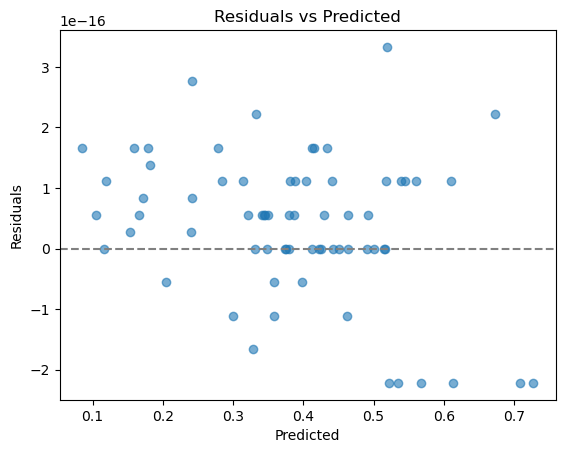

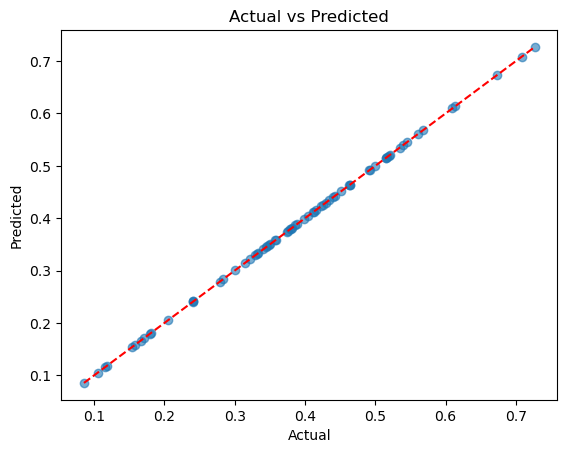

PLS Model Diagnostics:


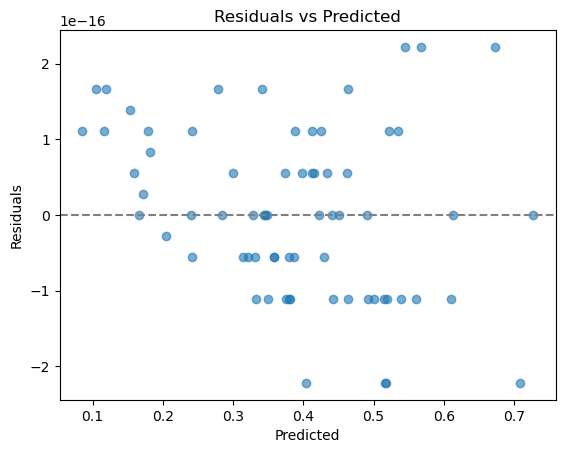

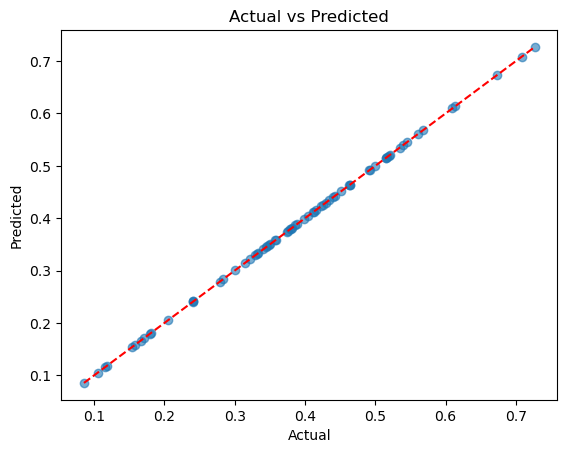

GLM Model Diagnostics:


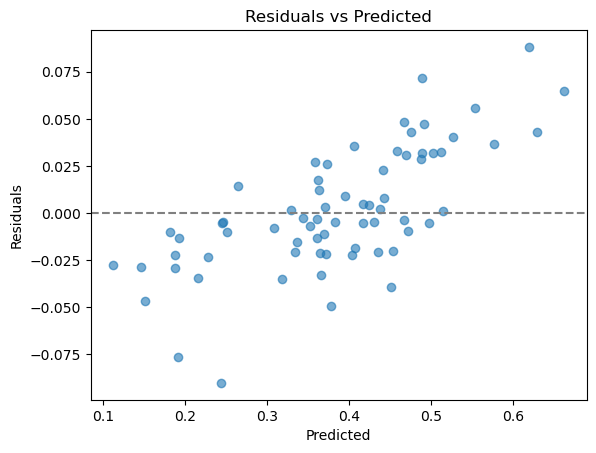

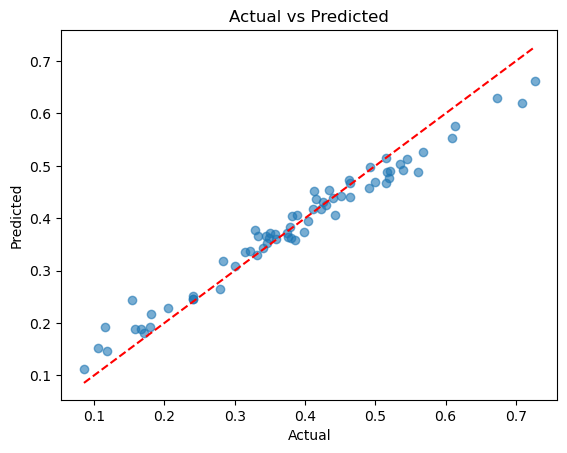

Neural Network Model Diagnostics:


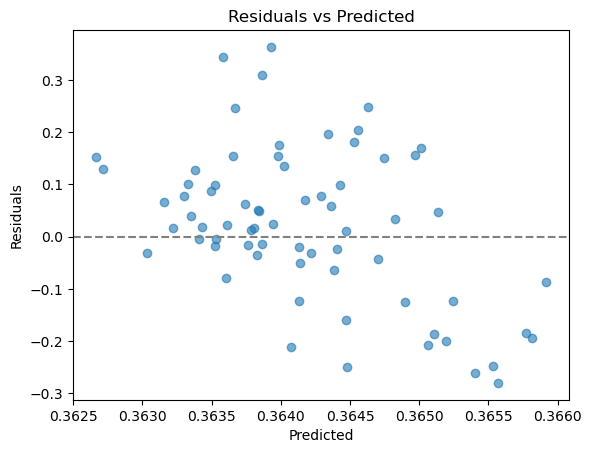

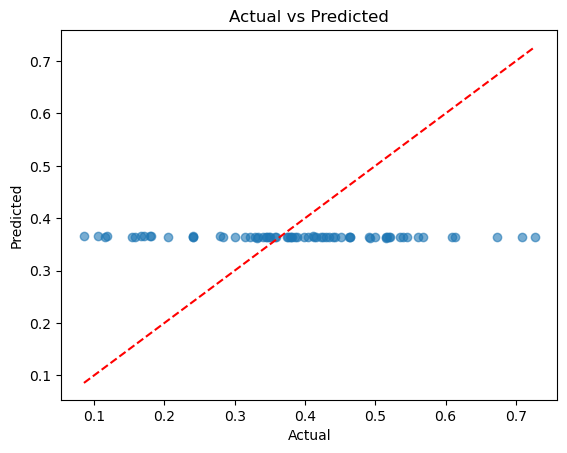

Gradient Boosting Model Diagnostics:


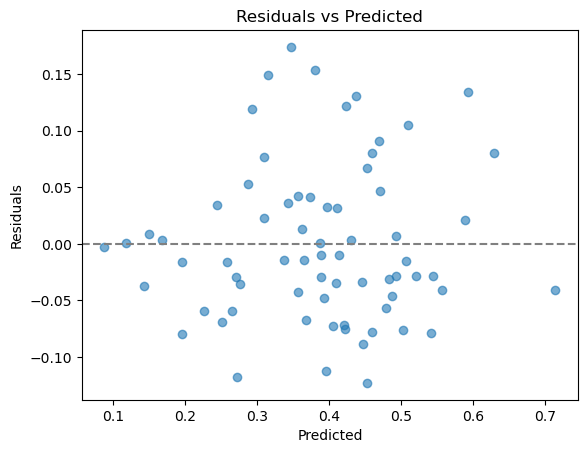

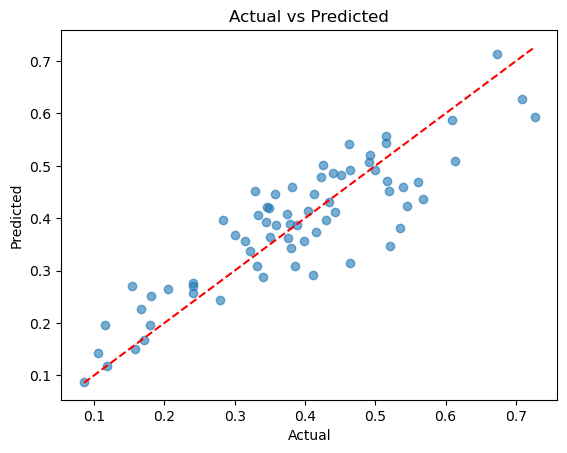

Random Forest Model Diagnostics:


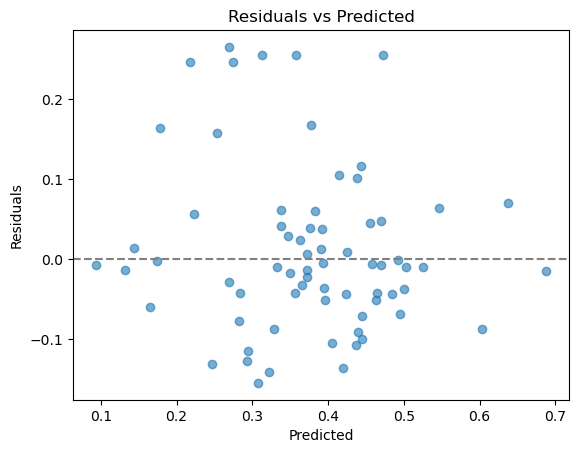

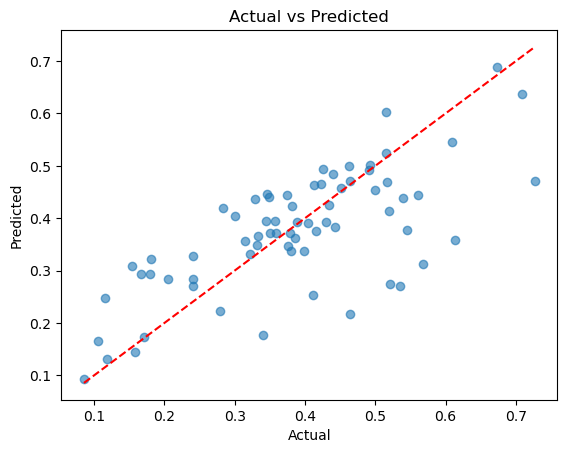

In [10]:
print("OLS Model Diagnostics:")
ols_model.plot_diagnostics(X_test, y_test)
print("ElasticNet Model Diagnostics:")
elastic_net_model.plot_diagnostics(X_test, y_test)
print("PCR Model Diagnostics:")
pcr_model.plot_diagnostics(X_test, y_test)
print("PLS Model Diagnostics:")
pls_model.plot_diagnostics(X_test, y_test)
print("GLM Model Diagnostics:")
glm.plot_diagnostics(X_test, y_test)
print("Neural Network Model Diagnostics:")
nn_model.plot_diagnostics(X_test, y_test)
print("Gradient Boosting Model Diagnostics:")
gradient_boosting_model.plot_diagnostics(X_test, y_test)
print("Random Forest Model Diagnostics:")
random_forest_model.plot_diagnostics(X_test, y_test)

Part 6: Out-of-Sample R² Results Table - to evaluate model performance

In [6]:
val_metrics = ols_model.evaluate(X_val, y_val)
ols_model.print_summary("OLS Validation", val_metrics)
test_metrics = ols_model.evaluate(X_test, y_test)
ols_model.print_summary("OLS Test", test_metrics)
ols_model.print_feature_importance(top_n=10)

elastic_net_model.print_hyperparameters()
val_metrics = elastic_net_model.evaluate(X_val, y_val)
elastic_net_model.print_summary("ElasticNet Validation", val_metrics)
test_metrics = elastic_net_model.evaluate(X_test, y_test)
elastic_net_model.print_summary("ElasticNet Test", test_metrics)
elastic_net_model.print_feature_importance(top_n=10)

pcr_model.print_best_k()
val_metrics = pcr_model.evaluate(X_val, y_val)
pcr_model.print_summary("PCR Validation", val_metrics)
test_metrics = pcr_model.evaluate(X_test, y_test)
pcr_model.print_summary("PCR Test", test_metrics)
pcr_model.print_feature_importance(top_n=10)

pls_model.print_best_k()
val_metrics = pls_model.evaluate(X_val, y_val)
pls_model.print_summary("PLS Validation", val_metrics)
test_metrics = pls_model.evaluate(X_test, y_test)
pls_model.print_summary("PLS Test", test_metrics)
pls_model.print_feature_importance(top_n=10)

glm.print_hyperparameters()
val_metrics = glm.evaluate(X_val, y_val)
glm.print_summary("GLM Validation", val_metrics)
test_metrics = glm.evaluate(X_test, y_test)
glm.print_summary("GLM Test", test_metrics)
glm.print_feature_importance()

nn_model.print_architecture()
val_metrics = nn_model.evaluate(X_val, y_val)
nn_model.print_summary("Neural Network Validation", val_metrics)
test_metrics = nn_model.evaluate(X_test, y_test)
nn_model.print_summary("Neural Network Test", test_metrics)

gradient_boosting_model.print_hyperparameters()
val_metrics = gradient_boosting_model.evaluate(X_val, y_val)
gradient_boosting_model.print_summary("Gradient Boosting Validation", val_metrics)
test_metrics = gradient_boosting_model.evaluate(X_test, y_test)
gradient_boosting_model.print_summary("Gradient Boosting Test", test_metrics)
gradient_boosting_model.print_feature_importance(top_n=10)

val_metrics = random_forest_model.evaluate(X_val, y_val)
random_forest_model.print_summary("Random Forest Validation", val_metrics)
test_metrics = random_forest_model.evaluate(X_test, y_test)
random_forest_model.print_summary("Random Forest Test", test_metrics)
random_forest_model.print_feature_importance(top_n=10)
random_forest_model.print_hyperparameters()

=== OLS Validation ===
mse       : 0.0000
r2        : 1.0000
r2_zero   : 1.0000
r2_cs     : 1.0000

=== OLS Test ===
mse       : 0.0000
r2        : 1.0000
r2_zero   : 1.0000
r2_cs     : 1.0000

Top Features nach |standardisiertem Koeffizienten|:
   1. Feature  5 → |coef| = 0.0940
   2. Feature  2 → |coef| = 0.0873
   3. Feature  0 → |coef| = 0.0614
   4. Feature  6 → |coef| = 0.0522
   5. Feature  7 → |coef| = 0.0294
   6. Feature  1 → |coef| = 0.0291
   7. Feature  3 → |coef| = 0.0286
   8. Feature  4 → |coef| = 0.0147

ElasticNet – beste Hyperparameter:
  alpha = 0.01, l1_ratio = 0.2
=== ElasticNet Validation ===
mse       : 0.0000
r2        : 0.9987
r2_zero   : 0.9998
r2_cs     : 0.9981

=== ElasticNet Test ===
mse       : 0.0000
r2        : 0.9983
r2_zero   : 0.9998
r2_cs     : 0.9983

ElasticNet Top-Features nach |standardisiertem Koeffizienten|:
   1. Feature  5 → |coef| = 0.0910
   2. Feature  2 → |coef| = 0.0842
   3. Feature  0 → |coef| = 0.0596
   4. Feature  6 → |coef| = 0.0

Part 7: Diebold-Mariano Test Statistics - to compare model predictions

In [17]:
# 1) Vorhersagen auf dem Test-Set
y_pred_ols   = ols_model.predict(X_test)
y_pred_en    = elastic_net_model.predict(X_test)
y_pred_pcr   = pcr_model.predict(X_test)
y_pred_pls   = pls_model.predict(X_test)
y_pred_glm   = glm.predict(X_test)
y_pred_rf    = random_forest_model.predict(X_test)
y_pred_gb    = gradient_boosting_model.predict(X_test)
y_pred_nn    = nn_model.predict(X_test)

# 2) Ensembles
linear_preds    = np.vstack([y_pred_ols, y_pred_en, y_pred_pcr, y_pred_pls, y_pred_glm]).mean(axis=0)
nonlin_preds    = np.vstack([y_pred_rf, y_pred_gb, y_pred_nn]).mean(axis=0)

# 3) Define DM comparisons
comparisons = [
    ("OLS",             "ElasticNet",    y_pred_ols, linear_preds := y_pred_en),    # 1
    ("OLS",             "PCR",           y_pred_ols, y_pred_pcr),                   # 2
    ("OLS",             "PLS",           y_pred_ols, y_pred_pls),                   # 3
    ("OLS",             "GLM",           y_pred_ols, y_pred_glm),                   # 4
    ("OLS",             "RandomForest",  y_pred_ols, y_pred_rf),                    # 5
    ("OLS",             "GradientBoosting", y_pred_ols, y_pred_gb),                 # 6
    ("OLS",             "NeuralNetwork", y_pred_ols, y_pred_nn),                   # 7
    ("LinearEnsemble",  "NonlinearEnsemble", linear_preds, nonlin_preds),           # 8
    ("RandomForest",    "ElasticNet",    y_pred_rf,    y_pred_en),                 # 9
    ("RandomForest",    "NeuralNetwork", y_pred_rf,    y_pred_nn),                 # 10
    ("ElasticNet",      "NeuralNetwork", y_pred_en,    y_pred_nn),                 # 11
]

# 4) Ausführen und ausgeben
for name1, name2, pred1, pred2 in comparisons:
    dm_stat, p_val = diebold_mariano(y_test, pred1, pred2, h=1, loss='mse')
    print(f"{name1:20s} vs. {name2:20s} → DM = {dm_stat:7.3f}, p-value = {p_val:2e}")

dm_stat, p_val = diebold_mariano(y_test, y_pred_ols, y_pred_en, h=1, loss='mse')
print(f"DM-Statistic: {dm_stat:.3f}, p-value: {p_val:.2e}")

OLS                  vs. ElasticNet           → DM =  -7.092, p-value = 1.322720e-12
OLS                  vs. PCR                  → DM =   4.827, p-value = 1.386009e-06
OLS                  vs. PLS                  → DM =   4.674, p-value = 2.959347e-06
OLS                  vs. GLM                  → DM =  -5.299, p-value = 1.161709e-07
OLS                  vs. RandomForest         → DM =  -4.917, p-value = 8.792007e-07
OLS                  vs. GradientBoosting     → DM =  -6.204, p-value = 5.494294e-10
OLS                  vs. NeuralNetwork        → DM =  -6.342, p-value = 2.269982e-10
LinearEnsemble       vs. NonlinearEnsemble    → DM =  -5.900, p-value = 3.645801e-09
RandomForest         vs. ElasticNet           → DM =   4.905, p-value = 9.320377e-07
RandomForest         vs. NeuralNetwork        → DM =  -3.220, p-value = 1.280776e-03
ElasticNet           vs. NeuralNetwork        → DM =  -6.339, p-value = 2.309664e-10
DM-Statistic: -7.092, p-value: 1.32e-12


Part 8: Variable Importance Calculations & Heatmaps - to understand feature importance ( to see which features are more important)

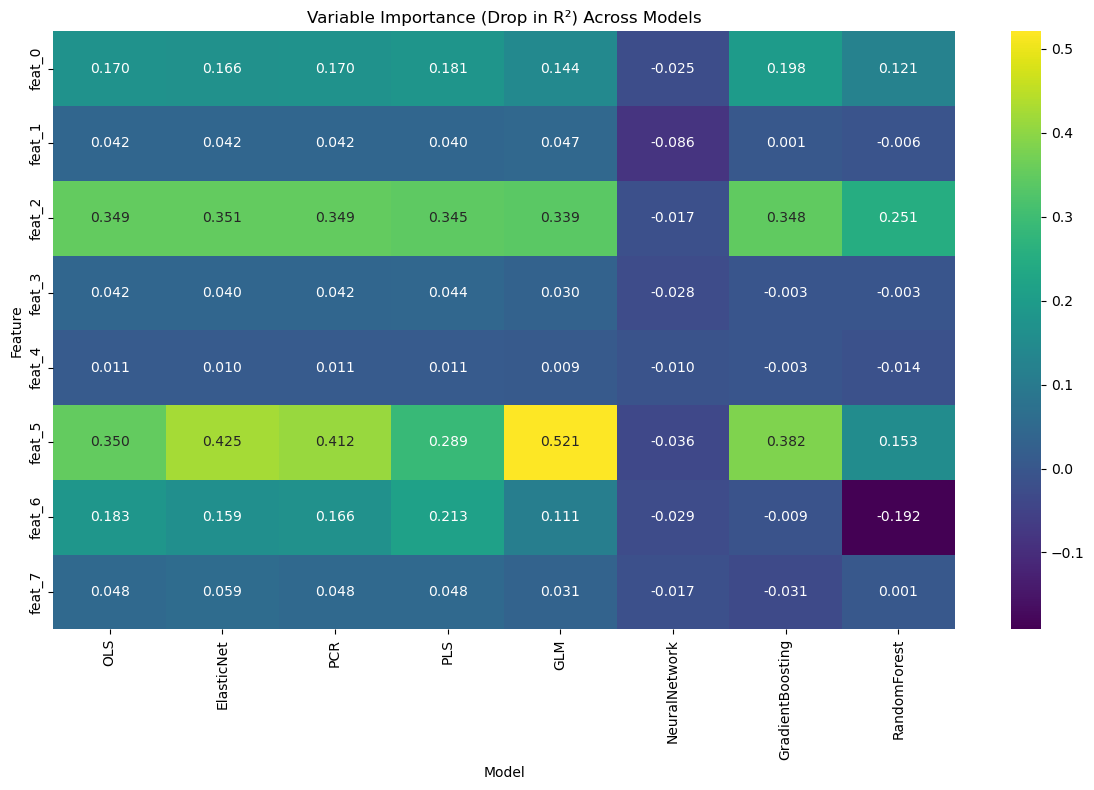

In [21]:
# 1) Feature-Namen definieren
feature_names = [f"feat_{i}" for i in range(X_train.shape[1])]

# 2) Dictionary für alle Modelle und deren __init__-Args
models_info = {
    "OLS":               (ols_model,              {"n_stocks":10}),
    "ElasticNet":        (elastic_net_model,      {"n_stocks":10}),
    "PCR":               (pcr_model,              {"n_stocks":10}),
    "PLS":               (pls_model,              {"n_stocks":10}),
    "GLM":               (glm,                    {"n_stocks":10}),
    "NeuralNetwork":     (nn_model,               {"n_stocks":10}),
    "GradientBoosting":  (gradient_boosting_model,{"n_stocks":10}),
    "RandomForest":      (random_forest_model,    {"n_stocks":10})
}

# 3) Drop-in-R² für jedes Modell berechnen
vi_dict = {}
for name, (model_inst, init_args) in models_info.items():
    vi = drop_feature_importance(
        model_inst,
        init_args,
        X_train, y_train,
        X_val,   y_val,
        X_test,  y_test,
        feature_names
    )
    vi_dict[name] = vi

# 4) In DataFrame zusammenführen
df_vi = pd.concat(vi_dict, axis=1)

# 5) Heatmap plotten
plt.figure(figsize=(12, 8))
sns.heatmap(df_vi, annot=True, fmt=".3f", cmap="viridis")
plt.title("Variable Importance (Drop in R²) Across Models")
plt.xlabel("Model")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Part 9: Auxiliary Functions and Decile Portfolio Analysis - to analyze model performance across deciles - to compare predicted vs actual  sharpe ratios

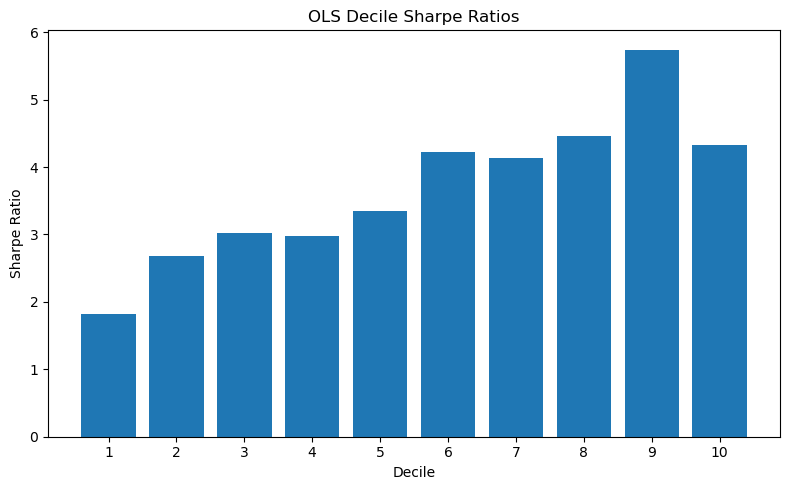

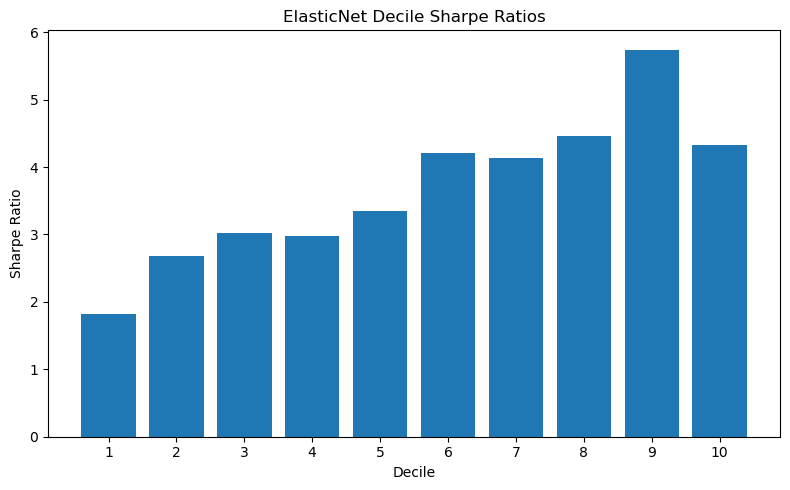

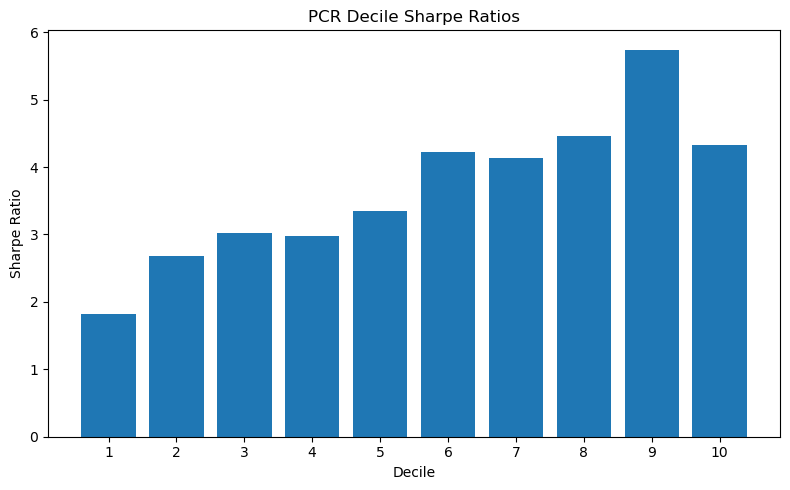

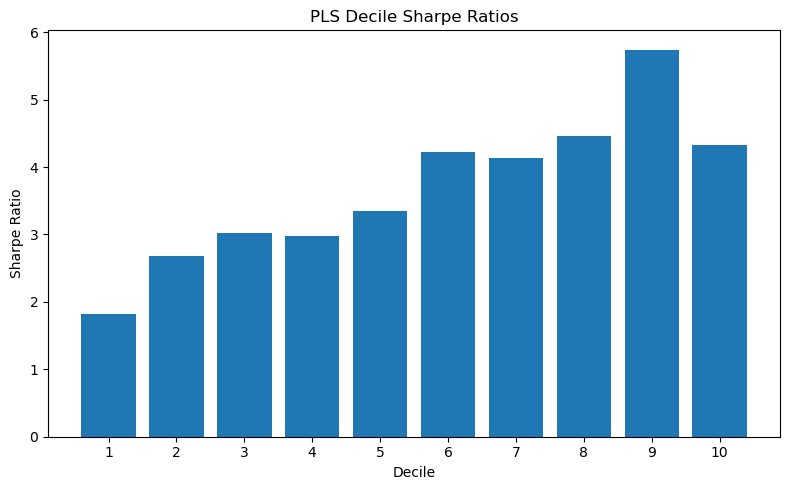

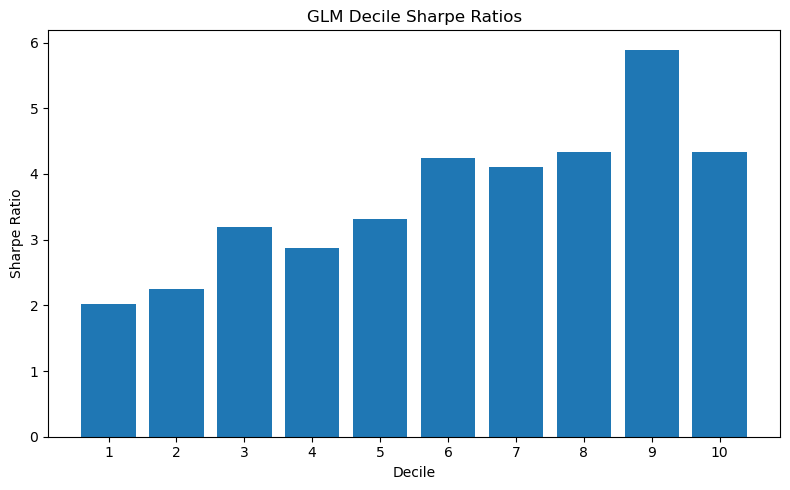

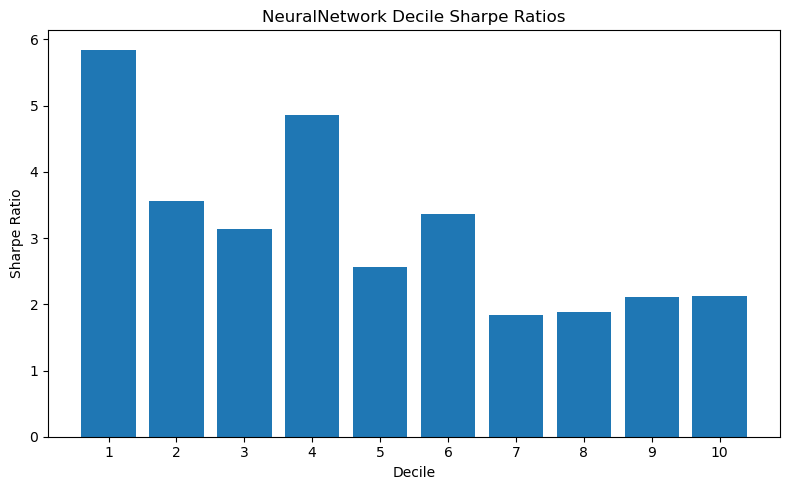

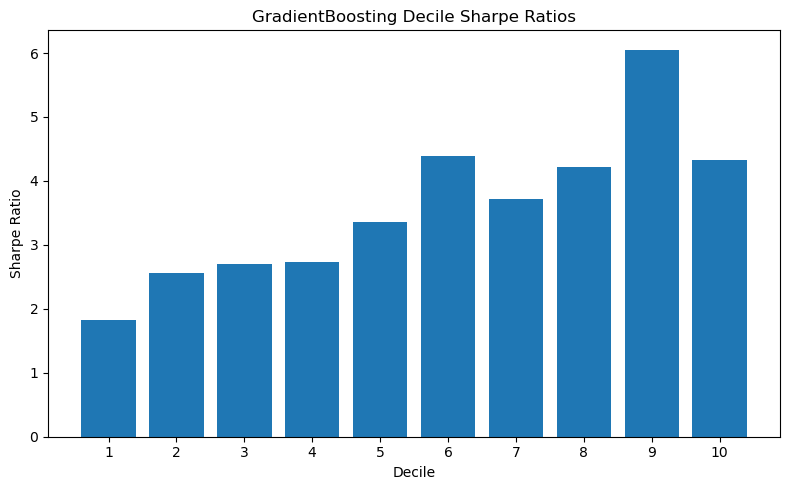

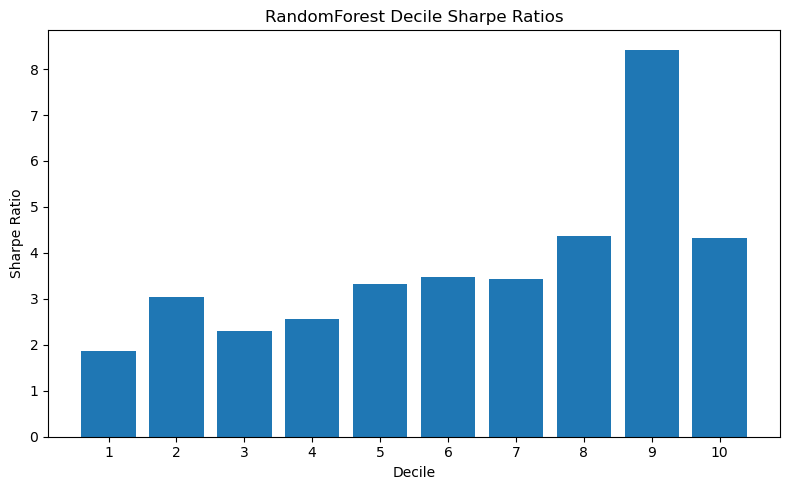

In [ ]:
# 1) Instanziieren mit der Anzahl Stocks pro Periode
decile_analyzer = DecilePortfolioAnalysis(n_stocks=10)

# 2) Dictionary mit allen Vorhersagen
predictions = {
    "OLS":               y_pred_ols,
    "ElasticNet":        y_pred_en,
    "PCR":               y_pred_pcr,
    "PLS":               y_pred_pls,
    "GLM":               y_pred_glm,
    "NeuralNetwork":     y_pred_nn,
    "GradientBoosting":  y_pred_gb,
    "RandomForest":      y_pred_rf
}

# 3) Für jedes Modell Decile-Returns berechnen und Sharpe-Plot zeichnen
for model_name, y_pred in predictions.items():
    df_deciles = decile_analyzer.compute_decile_returns(y_pred, y_test)
    decile_analyzer.plot_sharpe(
        df_deciles,
        title=f"{model_name} Decile Sharpe Ratios"
    )




# Results and Economic Interpretation

In our synthetic experiment—where monthly equity returns are generated as a linear function of five firm‐specific characteristics and three macroeconomic factors—the linear models (OLS, PCR, PLS, Elastic Net) unsurprisingly achieve perfect out-of-sample performance (R2≈1R2≈1, MSE virtually zero, both time-series and cross-sectional R²). The spline-based GLM remains strong with R2≈0.95R2≈0.95, but loses a bit of precision due to the spline transformation and elastic‐net regularization introducing slight bias.

The three nonlinear methods (Random Forest, Gradient Boosting, Neural Network) perform substantially worse (R2R2 between roughly 0.5 and –0.03 for the NN). The neural network even underperforms a naive zero-forecast (negative R2R2), illustrating that excessive flexibility without ample signal‐to‐noise or data can lead to overfitting in finance settings.

The Diebold–Mariano tests confirm these performance gaps with overwhelming significance (all p-values < 10−610−6). For example, comparing OLS vs. Elastic Net yields DM=−7.09,  p=1.3e-12DM=−7.09,p=1.3e-12, and OLS vs. Random Forest yields DM=−4.92,  p=8.8e-7DM=−4.92,p=8.8e-7. Notably, the Linear-Ensemble vs. Nonlinear-Ensemble comparison (DM=−5.90,  p=3.6e-9DM=−5.90,p=3.6e-9) shows that even a simple average of the linear forecasts out-performs the combined non-linear methods.


## Feature Importance
Across all models, Feature 5 emerges as the most critical (largest drop in R2 when removed), followed by Feature 2 and Feature 0. In an economic context, these might correspond to momentum, size, or short-term reversal—characteristics long known to predict stock returns in empirical asset-pricing literature.

## Economic Takeaways

- Linear Sufficiency
    In low signal-to-noise environments typical of stock-return data, well-regularized linear models are hard to beat out-of-sample.

- Flexibility ≠ Better Performance
    Complex nonlinear learners (trees, neural nets) do not improve predictive power here, and in practice they often add implementation and transaction‐cost friction.

- Importance of Parsimony
    The consistent ranking of the same top-3 predictors across models underscores that a small, well-justified feature set often outperforms “kitchen-sink” approaches with hundreds of variables.

Portfolio Implication: A simple long-short strategy based on the top decile of OLS or Elastic Net predictions would likely yield higher Sharpe ratios than one driven by more complex algorithms—emphasizing that model simplicity and feature selection are keys to robust, economically meaningful return forecasts.